In [1]:
import torch

def dfdx_equation(x: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
    """
    Derivative as per the given equation: du/dx + λu(κ + tan(λx)) = 0.
    
    Args:
        x (torch.Tensor): The independent variable.
        u (torch.Tensor): The dependent variable.
        lambda_ (float): The λ constant.
        kappa (float): The κ constant.
        
    Returns:
        torch.Tensor: The evaluated derivative.
    """
    return (-8) * u * (0.1 + torch.tan(8* x))


In [2]:
def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    """Compute a derivative of model that learns f(x), computes df/dx using torch.autograd."""
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs = torch.ones_like(inputs),
        create_graph = True,
        retain_graph = True,
    )[0]
    return grad

In [3]:
def loss_fn(model: torch.nn.Module, inputs: torch.Tensor, criterion: torch.nn.Module) -> torch.Tensor:
    """Loss function encoding the problem to solve."""
    # Equation loss
    model_output = model(inputs)  # Model output corresponds to u
    deriv_model = calc_deriv(model_output, inputs)  # Model derivative
    
    # Pass both x (inputs) and u (model_output) to dfdx_equation
    deriv_exact = dfdx_equation(inputs, model_output)
    ode_loss = criterion(deriv_model, deriv_exact)

    # Boundary loss, f(0) = 1
    boundary_model = model(torch.tensor([[0.0]]))
    boundary_exact = torch.tensor([[1.0]])
    boundary_loss = criterion(boundary_model, boundary_exact)

    return ode_loss + boundary_loss



In [4]:
from qadence import feature_map, hea, chain
from qadence import QNN, QuantumCircuit, Z
from qadence.types import BasisSet, ReuploadScaling

n_qubits = 3
depth = 3

# Feature map
fm = feature_map(
    n_qubits = n_qubits,
    param = "x",
    fm_type = BasisSet.CHEBYSHEV,
    reupload_scaling = ReuploadScaling.TOWER,
)

# Ansatz
ansatz = hea(n_qubits = n_qubits, depth = depth)

# Observable
observable = Z(0)

circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
model = QNN(circuit = circuit, observable = observable, inputs = ["x"])

INFO  2025-01-06 00:10:48 - pyqtorch: PyQTorch logger successfully setup with log level 20


Some stuff might fail: issue in joblib


In [5]:
n_epochs = 500
n_points = 10

xmin = 0.00
xmax = 0.99

optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

criterion = torch.nn.MSELoss()

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Training data. We unsqueeze essentially making each batch have a single x value.
    x_train = (xmin + (xmax - xmin) * torch.rand(n_points, requires_grad=True)).unsqueeze(1)

    loss = loss_fn(model=model, inputs=x_train, criterion=criterion)  # Pass criterion here
    loss.backward()
    optimizer.step()


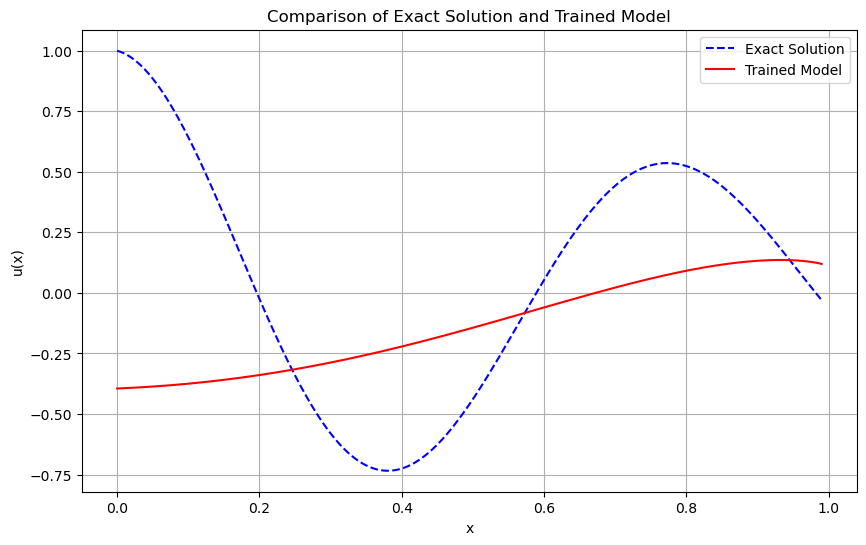

In [6]:
import matplotlib.pyplot as plt
import torch

# Define constants
lambda_ = 8  # λ
kappa = 0.1  # κ
C = 1.0  # Arbitrary constant for exact solution

# Define exact solution based on derived equation
def f_exact(x: torch.Tensor) -> torch.Tensor:
    return C * torch.exp(-lambda_ * kappa * x) * torch.cos(lambda_ * x)

# Generate test data points
x_test = torch.linspace(xmin, xmax, steps=200).unsqueeze(1)

# Compute exact solution
result_exact = f_exact(x_test).flatten()

# Get model predictions
result_model = model(x_test).detach().flatten()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_test.numpy(), result_exact.numpy(), label="Exact Solution", linestyle='--', color='blue')
plt.plot(x_test.numpy(), result_model.numpy(), label="Trained Model", linestyle='-', color='red')
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Comparison of Exact Solution and Trained Model")
plt.legend()
plt.grid()
plt.show()


In [7]:
from qadence import add, Z

# Define the observable as the sum of Z terms for each qubit
observable = add(Z(i) for i in range(n_qubits))

# Update the QNN model to use the new observable
model = QNN(circuit=circuit, observable=observable, inputs=["x"])

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Training loop
for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Generate training data
    x_train = (xmin + (xmax - xmin) * torch.rand(n_points, requires_grad=True)).unsqueeze(1)

    # Calculate loss
    loss = loss_fn(inputs=x_train, model=model, criterion=criterion)


    # Backpropagation and optimization step
    loss.backward()
    optimizer.step()



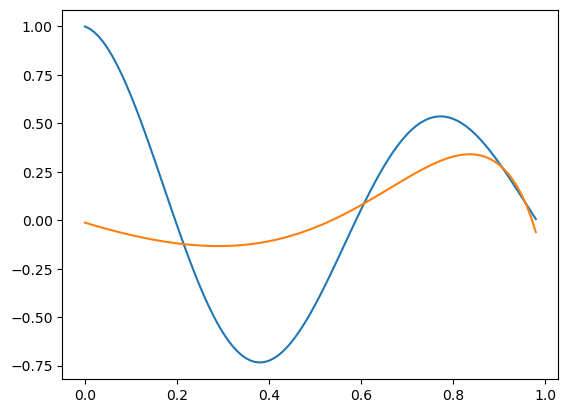

In [8]:
x_test = torch.arange(xmin, xmax, step = 0.01).unsqueeze(1)

result_exact = f_exact(x_test).flatten()

result_model = model(x_test).flatten().detach()

plt.plot(x_test, result_exact, label = "Exact solution")
plt.plot(x_test, result_model, label = "Trained model")